In [1]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.operators import PolynomialTensor
from qiskit_nature.second_q.properties import ElectronicDipoleMoment
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
import numpy as np 
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA , SLSQP, L_BFGS_B, SPSA, NELDER_MEAD
from qiskit_algorithms import VQE
from qiskit_algorithms.eigensolvers import NumPyEigensolver
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector 


Gamma = 0.25
E0 = 0.01

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
hamiltonian = problem.hamiltonian
dipole: ElectronicDipoleMoment  = problem.properties.electronic_dipole_moment

mapper = JordanWignerMapper()
dipole_ops = dipole.second_q_ops()

# Lấy toán tử moment lưỡng cực từ phương Z (vì X và Y rỗng)
x_dipole_op = dipole_ops["XDipole"]
y_dipole_op = dipole_ops["YDipole"]
z_dipole_op = dipole_ops["ZDipole"]

qubit_dipole_ops = {
    "XDipole": mapper.map(x_dipole_op),
    "YDipole": mapper.map(y_dipole_op),
    "ZDipole": mapper.map(z_dipole_op),
}

qubit_dipole_ops_matrix = {
    "XDipole": qubit_dipole_ops["XDipole"].to_matrix(),
    "YDipole": qubit_dipole_ops["YDipole"].to_matrix(),
    "ZDipole": qubit_dipole_ops["ZDipole"].to_matrix(),
}

dipole_qubit = qubit_dipole_ops["XDipole"] + qubit_dipole_ops["YDipole"] + qubit_dipole_ops["ZDipole"]  # Toán tử moment lưỡng cực Z dưới dạng SparsePauliOp
dipole_matrix = qubit_dipole_ops_matrix["XDipole"] + qubit_dipole_ops_matrix["YDipole"] + qubit_dipole_ops_matrix["ZDipole"]  # Ma trận của toán tử moment lưỡng cực Z

# z_dipole_qubit = qubit_dipole_ops["ZDipole"]  # Toán tử moment lưỡng cực Z dưới dạng SparsePauliOp
# z_dipole_matrix = z_dipole_qubit.to_matrix()  # Ma trận của toán tử moment lưỡng cực Z

second_q_op = hamiltonian.second_q_op()
qubit_jw_op = mapper.map(second_q_op) 

H_0 = qubit_jw_op # H_0 (static) dưới dạng SparsePauliOp
H_static = H_0.to_matrix()  # Matrix of 

ansatz = UCC(
    num_spatial_orbitals = problem.num_spatial_orbitals, #2
    num_particles = problem.num_particles, # [1, 1]
    excitations='sd',
    qubit_mapper=mapper,
    initial_state=HartreeFock(
        num_spatial_orbitals = problem.num_spatial_orbitals,
        num_particles = problem.num_particles, 
        qubit_mapper=mapper,
    ),
    reps=1,

)

estimator = Estimator()
optimizer = SLSQP(maxiter=200)
vqe = VQE(estimator, ansatz, optimizer)
res = vqe.compute_minimum_eigenvalue(qubit_jw_op)

numpy_solver = NumPyEigensolver()
exact_result = numpy_solver.compute_eigenvalues(qubit_jw_op)
ref_value = exact_result.eigenvalues

circuit = ansatz.assign_parameters(res.optimal_parameters)
psi_0_vqe = np.array(Statevector(circuit).data)

def Hamilton_SP(t, H_0, z_dipole_qubit, E0, Gamma):
    t_float = float(t)  # Chuyển đổi t sang float 
    E_t = (E0 / np.pi) * Gamma / (Gamma**2 + t_float**2)
    V_t = E_t*z_dipole_qubit
    H_total_q = H_0 + V_t
    return H_total_q

def H_time(t):
    return Hamilton_SP(t, H_0, dipole_qubit, E0, Gamma)

In [2]:
static_pauli_op = H_0 
static_labels = static_pauli_op.paulis.to_labels()
dipole_pauli_op = dipole_qubit
dipole_interaction_labels = dipole_pauli_op.paulis.to_labels()
combined_unique_labels = list(dict.fromkeys(static_labels + dipole_interaction_labels))
num_qubits = H_0.num_qubits

In [3]:
from qiskit.quantum_info import random_unitary
from qiskit.circuit.library import UnitaryGate
from sync import cost as cost_func
from sync import circuit, constant
import pennylane.numpy as np
import pennylane as qml
%load_ext autoreload
%autoreload 2

In [4]:
def pennylane_ansatz_from_qiskit_pauli_evo(thetas, num_qubits, pauli_labels, num_layers):
    """
Tạo một ansatz Pennylane tương đương với việc áp dụng một chuỗi các PauliEvolutionGate của Qiskit.
Cấu trúc của Qiskit ansatz: U(theta) = product_L (product_k exp(-i * theta_Lk * P_k))
Trong Pennylane, qml.exp(op, coeff) thực hiện exp(coeff * op).
Chúng ta muốn thực hiện exp(-i * theta_Lk * P_k), vậy:
    op = P_k (dưới dạng PauliWord của Pennylane)
    coeff = -1j * theta_Lk

Args:
    thetas (np.ndarray): Mảng 1D các tham số theta, được làm phẳng (flattened).
                            Thứ tự phải khớp với cách Qiskit ansatz sử dụng chúng
                            (tức là, tất cả các theta cho lớp 1, sau đó tất cả cho lớp 2, v.v.).
    num_qubits (int): Số qubit của hệ thống.
    pauli_labels (list[str]): Danh sách các chuỗi Pauli CỐ ĐỊNH (P_k)
                                    dưới dạng chuỗi ký tự kiểu Qiskit (ví dụ: "IXYZ", "ZZI").
                                    Độ dài mỗi chuỗi phải bằng num_qubits.
    num_layers (int): Số lớp (N_L) của ansatz.
"""
    if not pauli_labels:
        raise ValueError("pauli_labels must not be empty.")


    num_params_per_layer = len(pauli_labels)
    num_params_expected = num_params_per_layer * num_layers

    if len(thetas) != num_params_expected:
         raise ValueError(f"Expected {num_params_expected} parameters, got {len(thetas)}.")

    
    param_idx = 0
    for _ in range(num_layers):
        for pauli_qiskit_str in pauli_labels:
            if len(pauli_qiskit_str) != num_qubits:
                raise ValueError(f"Pauli string '{pauli_qiskit_str}' does not match num_qubits={num_qubits}.")
            
            pennylane_observable = None
            if all(c == 'I' for c in pauli_qiskit_str):
                if num_qubits > 0:
                    pennylane_observable = qml.Identity(0)
                    for i_w in range(1, num_qubits): pennylane_observable @= qml.Identity(i_w)
                elif num_qubits == 0: pennylane_observable = qml.Identity(0)
                else: raise ValueError("Số qubit phải không âm.")
            else:
                try: pennylane_observable = qml.pauli.string_to_pauli_word(pauli_qiskit_str)
                except AttributeError:

                    ops_list = []
                    for i_wire in range(num_qubits):
                        char = pauli_qiskit_str[i_wire]
                        if char == 'X': ops_list.append(qml.PauliX(i_wire))
                        elif char == 'Y': ops_list.append(qml.PauliY(i_wire))
                        elif char == 'Z': ops_list.append(qml.PauliZ(i_wire))
                        elif char == 'I': pass
                        else: raise ValueError(f"Ký tự Pauli không hợp lệ '{char}'")

                    if not ops_list and num_qubits > 0:
                         pennylane_observable = qml.Identity(0)
                         for i_w in range(1, num_qubits): pennylane_observable @= qml.Identity(i_w)
                    elif ops_list: pennylane_observable = qml.prod(*ops_list)
                    else: raise ValueError(f"Không tạo được observable từ '{pauli_qiskit_str}'")
            if pennylane_observable is not None: qml.exp(pennylane_observable, -1j * thetas[param_idx])
            param_idx += 1
# --- Kết thúc hàm ansatz ---

In [5]:

import numpy as np
from scipy.integrate import solve_ivp
import time

# --- Định nghĩa lại các thành phần cần thiết ---
H0_matrix = H_static
Dz_matrix = dipole_matrix

dim = H0_matrix.shape[0]
U0_flat = np.eye(dim, dtype=complex).flatten() # U(0) = I, làm phẳng cho solver

# Hàm E-field
E0 = 0.01
Gamma = 0.25

def E_field(t):
    if t < -200 or t > 200: return 0.0
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

# Hàm H(t)
def H_t_matrix(t):
    return H0_matrix + E_field(t) * Dz_matrix

# --- Định nghĩa vế phải của PT vi phân cho Unitary: dU/dt = -i * H(t) * U ---
def unitary_rhs(t, U_flat):
    U = U_flat.reshape(dim, dim) # Chuyển vector về ma trận
    H = H_t_matrix(t)
    dU_dt = -1j * (H @ U)
    return dU_dt.flatten() # Chuyển về vector cho solver

# --- Thiết lập thời gian và chạy solver ---
# Dùng các điểm thời gian này để huấn luyện
times_for_training = np.linspace(0, 300, 50) 
t_span = [times_for_training[0], times_for_training[-1]]

print("Bắt đầu tính toán Target Unitaries bằng ODE Solver...")
start_time = time.time()
sol_U = solve_ivp(
    unitary_rhs,
    t_span,
    U0_flat,
    t_eval=times_for_training,
    method='RK45', # Phương pháp Runge-Kutta bậc 4(5)
    rtol=1e-8, # Dung sai cao để có kết quả chính xác
    atol=1e-8
)
end_time = time.time()
print(f"Hoàn thành trong {end_time - start_time:.2f} giây.")

# --- Xử lý kết quả ---
target_unitaries_list = []
if sol_U.success:
    # sol_U.y có dạng (dim*dim, N_points)
    unitaries_flat = sol_U.y.T # Chuyển vị thành (N_points, dim*dim)
    for u_flat in unitaries_flat:
        target_unitaries_list.append(u_flat.reshape(dim, dim))
    print(f"Đã tạo thành công {len(target_unitaries_list)} target unitaries.")
else:
    print("Lỗi: Bộ giải ODE không hội tụ khi tính toán Unitary.")


Bắt đầu tính toán Target Unitaries bằng ODE Solver...
Hoàn thành trong 0.19 giây.
Đã tạo thành công 50 target unitaries.


In [6]:
import math
import numpy as np
import pennylane as qml
import pennylane.numpy as pnp
from numpy.random import Generator, PCG64

# --- CONFIGURATION ---
num_layers = 6
times = np.linspace(0, 300, 50)
steps = 300
learning_rate = 0.01
error_threshold = constant.error

num_qubits = H_0.num_qubits
pauli_labels = combined_unique_labels
num_thetas = len(pauli_labels) * num_layers
rng = Generator(PCG64())
init_thetas = pnp.array(2 * math.pi * rng.random(size=num_thetas), requires_grad=True)



def vqa_cost(thetas, num_qubits, pauli_labels, num_layers, target_unitary):
    ansatz_matrix = qml.matrix(pennylane_ansatz_from_qiskit_pauli_evo, wire_order=list(range(num_qubits)))(
        thetas, num_qubits, pauli_labels, num_layers
    )
    return cost_func.c_hst(ansatz_matrix, target_unitary)

def get_ansatz_tape(thetas, num_qubits, pauli_labels, num_layers):
    with qml.tape.QuantumTape() as tape:
        pennylane_ansatz_from_qiskit_pauli_evo(thetas, num_qubits, pauli_labels, num_layers)
    return tape

def train_vqa_for_time(target_unitary, num_qubits, pauli_labels, num_layers, init_thetas, steps, learning_rate, error_threshold):
    opt = qml.AdamOptimizer(stepsize=learning_rate)
    thetas = init_thetas.copy()
    cost_history = []
    for n in range(steps):
        cost_fn = lambda th: vqa_cost(th, num_qubits, pauli_labels, num_layers, target_unitary)
        thetas, prev_cost = opt.step_and_cost(cost_fn, thetas)
        if (n + 1) % (steps // 2 if steps >= 2 else 1) == 0:
            print(f"    Opt. step {n+1}/{steps}, Cost: {prev_cost:.6f}")
        if prev_cost < error_threshold:
            print(f"    Reached error threshold at step {n+1}")
            # break
        cost_history.append(prev_cost)
    return thetas, cost_history

optimized_unitaries = {}
evolved_states = {}
depths_vqc = []
cnots_vqc = []

print("Starting VQA time evolution simulation with Pennylane")
for i, t in enumerate(times):
    print(f"\n--- Time t = {t:.4f} ---")
    target = target_unitaries_list[i]
    thetas, cost_history = train_vqa_for_time(
        target, num_qubits, pauli_labels, num_layers, init_thetas,
        steps=steps, learning_rate=learning_rate, error_threshold=error_threshold
    )
    tape = get_ansatz_tape(thetas, num_qubits, pauli_labels, num_layers)
    depth = tape.graph.depth()
    # Đếm số CNOT (Pennylane gọi là 'CNOT')
    cnot_count = sum(1 for op in tape.operations if op.name.upper() == 'CNOT')
    depths_vqc.append(depth)
    cnots_vqc.append(cnot_count)
    print(f"t={t:.2f} | VQC depth: {depth} | CNOT count: {cnot_count}")
    
    U_theta_t = qml.matrix(
        pennylane_ansatz_from_qiskit_pauli_evo, wire_order=range(num_qubits)
    )(thetas, num_qubits, pauli_labels, num_layers)
    optimized_unitaries[t] = U_theta_t.numpy() if hasattr(U_theta_t, 'numpy') else np.asarray(U_theta_t)
    psi_0_col = psi_0_vqe.reshape(-1, 1)
    psi_t_col_approx = optimized_unitaries[t] @ psi_0_col
    psi_t_approx = psi_t_col_approx.flatten()
    evolved_states[t] = psi_t_approx

Starting VQA time evolution simulation with Pennylane

--- Time t = 0.0000 ---
    Opt. step 150/300, Cost: 0.146447
    Opt. step 300/300, Cost: 0.146447


AttributeError: 'CircuitGraph' object has no attribute 'depth'

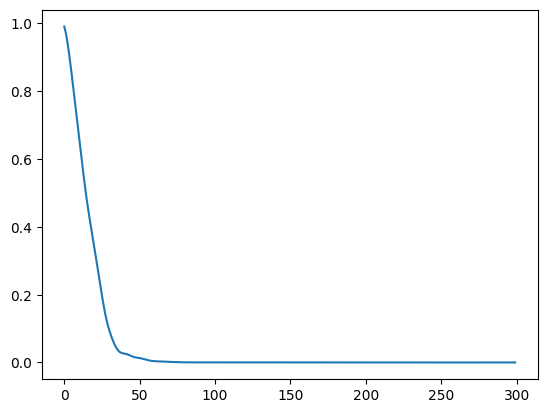

In [94]:
import matplotlib.pyplot as plt
plt.plot(cost_history)

In [101]:
# CELL MỚI: XUẤT GIÁ TRỊ TỪ LIST 'COSTS' RA FILE

import numpy as np

output_filename = "cost_thesis_perfect.txt"

try:
    # --- Bước 1: Kiểm tra sự tồn tại của biến 'costs' ---
    if 'costs' not in locals():
        raise NameError("Không tìm thấy biến 'costs'. Vui lòng chạy lại một ô code có quá trình tối ưu hóa để tạo ra biến này.")

    # --- Bước 2: Trích xuất giá trị số (float) từ mỗi tensor ---
    # Dùng list comprehension để tạo một list mới chỉ chứa các con số
    numeric_costs = [float(c) for c in cost_history]
    
    print(f"Đã trích xuất thành công {len(numeric_costs)} giá trị cost từ lần chạy cuối.")

    # --- Bước 3: Ghi kết quả ra file ---
    print(f"Đang ghi kết quả ra file '{output_filename}'...")
    
    with open(output_filename, "w") as f:
        # Ghi dòng tiêu đề cho các cột
        f.write("# Optimization_Step   Cost_Value\n")
        
        # Lặp qua dữ liệu và ghi ra file
        for step, cost_value in enumerate(numeric_costs):
            # step + 1 để bắt đầu từ bước 1
            f.write(f"{step + 1:<20} {cost_value:<.12f}\n")
            
    print(f"\nHoàn tất! Đã lưu thành công lịch sử cost vào file '{output_filename}'.")

except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")

Đã trích xuất thành công 300 giá trị cost từ lần chạy cuối.
Đang ghi kết quả ra file 'cost_thesis_perfect.txt'...

Hoàn tất! Đã lưu thành công lịch sử cost vào file 'cost_thesis_perfect.txt'.


In [158]:
# --- Hàm giải phương trình Schrödinger chính xác bằng ODE Solver ---
from scipy.integrate import solve_ivp
from qiskit.quantum_info import Statevector, Operator
import numpy as np
import time

# --- Hàm tính giá trị kỳ vọng (sửa để xử lý lỗi "not contiguous") ---
def calculate_expectation_value_robust(state_vector_flat, pauli_op_sparse):
    if pauli_op_sparse is None or state_vector_flat is None:
        return np.nan
    # Lỗi "not contiguous" xảy ra do cách Scipy lưu trữ dữ liệu.
    # np.ascontiguousarray() sẽ tạo một bản sao với bộ nhớ liền mạch.
    try:
        sv = Statevector(np.ascontiguousarray(state_vector_flat))
        exp_val = sv.expectation_value(pauli_op_sparse)
        return exp_val.real
    except Exception as e_exp:
        # Lỗi này không nên xảy ra nữa, nhưng vẫn để lại để debug
        print(f"    Lỗi khi tính giá trị kỳ vọng: {e_exp}")
        return np.nan


# Sử dụng lại các mảng `times` và `psi_0_vqe` từ các ô trước
# times = np.linspace(0, 100, 20)
# times_for_ode_plot = times
initial_state_vec_for_ode = psi_0_vqe
E0 = 0.01
Gamma = 0.25
H0_matrix = H_static
Dz_matrix = dipole_matrix

# Lấy các ma trận cần thiết đã tính ở ô trên
# H_static_mat_for_ode = H_0.to_matrix(sparse=False)
# z_dipole_mat_for_ode = dipole_matrix
# # Định nghĩa lại hàm E(t) để code dễ đọc
# E0_val_for_ode = 0.01
# Gamma_val_for_ode = 0.25
# Hàm E-field
# def E_field_for_ode(t):
#     return (E0_val_for_ode / np.pi) * Gamma_val_for_ode / (Gamma_val_for_ode**2 + t**2)

dim = H0_matrix.shape[0]
U0_flat = np.eye(dim, dtype=complex).flatten() # U(0) = I, làm phẳng cho solver

def E_field(t):
    if t < -200 or t > 200: return 0.0
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

# Hàm H(t)
def H_t_matrix(t):
    return H0_matrix - E_field(t) * Dz_matrix

# Đây là hàm f(t, y) trong dy/dt = f(t, y), với y là vector trạng thái psi
def schrodinger_rhs(t, psi_flat):
    H_t_mat = H0_matrix - E_field(t) * Dz_matrix
    return -1j * H_t_mat @ psi_flat

# --- Định nghĩa vế phải của PT vi phân cho Unitary: dU/dt = -i * H(t) * U ---
def unitary_rhs(t, U_flat):
    U = U_flat.reshape(dim, dim) # Chuyển vector về ma trận
    H = H_t_matrix(t)
    dU_dt = -1j * (H @ U)
    return dU_dt.flatten() # Chuyển về vector cho solver

# --- Thiết lập thời gian và chạy solver ---
# Dùng các điểm thời gian này để huấn luyện
times_for_training = np.linspace(0, 300, 50) 
t_span = [times_for_training[0], times_for_training[-1]]

print("Bắt đầu tính toán Target Unitaries bằng ODE Solver...")
start_time = time.time()
sol_U = solve_ivp(
    unitary_rhs,
    t_span,
    U0_flat,
    t_eval=times_for_training,
    method='RK45', # Phương pháp Runge-Kutta bậc 4(5)
    rtol=1e-8, # Dung sai cao để có kết quả chính xác
    atol=1e-8
)
end_time = time.time()
print(f"Hoàn thành trong {end_time - start_time:.2f} giây.")

# --- Xử lý kết quả ---
target_unitaries_list = []
if sol_U.success:
    # sol_U.y có dạng (dim*dim, N_points)
    unitaries_flat = sol_U.y.T # Chuyển vị thành (N_points, dim*dim)
    for u_flat in unitaries_flat:
        target_unitaries_list.append(u_flat.reshape(dim, dim))
    print(f"Đã tạo thành công {len(target_unitaries_list)} target unitaries.")
else:
    print("Lỗi: Bộ giải ODE không hội tụ khi tính toán Unitary.")


print("Bắt đầu chạy mô phỏng chính xác (ODE)...")
start_run_time = time.time()
ode_solution = solve_ivp(
    schrodinger_rhs,
    t_span,
    y0=initial_state_vec_for_ode,
    t_eval=times_for_training,
    rtol=1e-8,
    atol=1e-8
)

if ode_solution.success:
    print("Giải ODE thành công.")
    all_psi_t_exact_ode = ode_solution.y.T
else:
    print("Giải ODE thất bại:", ode_solution.message)
    all_psi_t_exact_ode = np.array([initial_state_vec_for_ode] * len(times_for_training))

# --- Tính giá trị kỳ vọng dipole moment từ kết quả chính xác này ---
muz_plot_exact_ode = []
for psi_t in all_psi_t_exact_ode:
    # Sử dụng hàm đã được sửa lỗi
    exp_val = calculate_expectation_value_robust(psi_t, dipole_qubit)
    muz_plot_exact_ode.append(exp_val)

end_run_time = time.time()
print(f"Đã tính xong dipole moment từ kết quả ODE. Thời gian: {end_run_time - start_run_time:.2f} giây")

Bắt đầu tính toán Target Unitaries bằng ODE Solver...
Hoàn thành trong 0.25 giây.
Đã tạo thành công 50 target unitaries.
Bắt đầu chạy mô phỏng chính xác (ODE)...
Giải ODE thành công.
Đã tính xong dipole moment từ kết quả ODE. Thời gian: 0.24 giây


In [80]:
import numpy as np
from scipy.linalg import expm 
from qiskit.quantum_info import Operator, Statevector 
import time

# --- Cấu hình và các hàm pomocniczy (giữ nguyên từ trước) ---

D_mat = dipole_matrix     
DIM = 2**num_qubits
Gamma = 0.25
E0 = 0.01

def f_lorentzian(t, E0, Gamma): 
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

def f_integral(t_start, t_end, E0, Gamma):
    return (E0/ np.pi) * (np.arctan(t_end / Gamma) - np.arctan(t_start / Gamma))

def trapezoidal_weights(n_points):
    if n_points <= 1: return np.array([1.0]) if n_points == 1 else np.array([])
    weights_val = np.ones(n_points)
    weights_val[0] = weights_val[-1] = 0.5
    return weights_val * (1.0 / (n_points - 1))

print("Tính toán trước [H0, D]...")
Comm_H0_D = H_static @ D_mat -  D_mat @ H_static

M_inner_integral = 50 # Số điểm tích phân cho mỗi bước Magnus

def compute_U_step_magnus2(t_j_start, h_step): 
    if h_step == 0:
        return np.eye(DIM, dtype=complex)
    
    Omega1 = -1j * (H_static * h_step + D_mat * f_integral(t_j_start, t_j_start + h_step, E0, Gamma))
    
    Omega2 = np.zeros((DIM, DIM), dtype=complex)
    if M_inner_integral > 1:
        t_points_inner = np.linspace(t_j_start, t_j_start + h_step, M_inner_integral)
        delta_t_inner = h_step / (M_inner_integral - 1)
        weights_inner = trapezoidal_weights(M_inner_integral) * delta_t_inner
        f_values_inner = f_lorentzian(t_points_inner, E0, Gamma)

        for p in range(M_inner_integral):
            t1 = t_points_inner[p]
            f_t1 = f_values_inner[p]
            integral_f_t2_up_to_t1 = f_integral(t_j_start, t1, E0, Gamma)
            term_for_outer_integral = integral_f_t2_up_to_t1 - (f_t1 * (t1 - t_j_start))
            Omega2 += term_for_outer_integral * Comm_H0_D * weights_inner[p]
            
    Omega2 *= -0.5
    
    Omega = Omega1 + Omega2
    U_step = expm(Omega)
    return U_step

# --- Thuật toán mô phỏng mới với bước thời gian nhỏ ---
print("\\nBắt đầu mô phỏng Magnus bậc 2 với bước thời gian nhỏ...")
start_run_time = time.time()


# Các điểm thời gian chúng ta muốn LƯU kết quả
times = np.linspace(0,300,50)
times_plot = times # Sử dụng lại mảng times từ các ô trước

# Bước thời gian NHỎ dùng để tính toán Magnus
dt_magnus = 0.1 

# Điểm thời gian cuối cùng cần tính
T_final = times_plot[-1]

# Khởi tạo
current_t = 0.0
# Lưu trạng thái tại các thời điểm mong muốn
all_psi_t_magnus_map = {0.0: Statevector(psi_0_vqe)}
# Trạng thái hiện tại trong vòng lặp
psi_current_iter = Statevector(psi_0_vqe)
# Index cho mảng times_plot
plot_idx = 1 # Bắt đầu từ 1 vì t=0 đã có

while current_t < T_final and plot_idx < len(times_plot):
    # Tính bước nhảy h cho đến điểm cần vẽ đồ thị tiếp theo
    h = times_plot[plot_idx] - current_t
    
    # Chia bước h này thành nhiều bước dt_magnus nhỏ hơn
    num_sub_steps = max(1, int(np.ceil(h / dt_magnus)))
    dt_sub_step = h / num_sub_steps

    psi_at_h = psi_current_iter
    
    for i in range(num_sub_steps):
        t_sub_step_start = current_t + i * dt_sub_step
        U_sub_step = compute_U_step_magnus2(t_sub_step_start, dt_sub_step)
        psi_at_h = psi_at_h.evolve(Operator(U_sub_step))

    # Lưu kết quả tại điểm mong muốn
    all_psi_t_magnus_map[times_plot[plot_idx]] = psi_at_h
    
    # Cập nhật cho vòng lặp tiếp theo
    current_t = times_plot[plot_idx]
    psi_current_iter = psi_at_h
    plot_idx += 1
    
end_run_time = time.time()
print(f"Hoàn thành mô phỏng. Thời gian: {end_run_time - start_run_time:.2f} giây")


Tính toán trước [H0, D]...
\nBắt đầu mô phỏng Magnus bậc 2 với bước thời gian nhỏ...
Hoàn thành mô phỏng. Thời gian: 0.97 giây


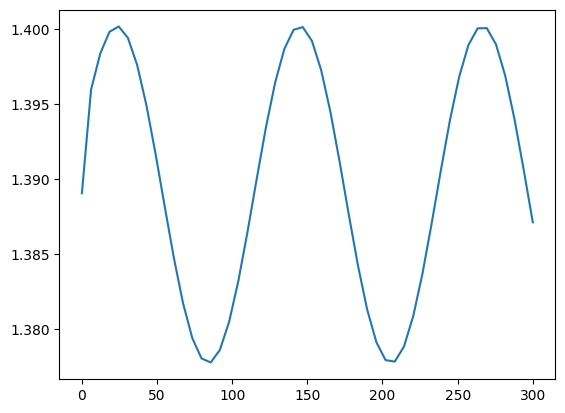

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp 
import qiskit 




def calculate_expectation_value(state_vector_flat, pauli_op_sparse):
    if pauli_op_sparse is None or state_vector_flat is None:
        return np.nan
    sv = Statevector(state_vector_flat)
    try:
        exp_val = sv.expectation_value(pauli_op_sparse)
        return exp_val.real 
    except Exception as e_exp:
        print(f"    Lỗi khi tính giá trị kỳ vọng: {e_exp}")
        return np.nan
    
times_plot_magnus2 = []
muz_plot_magnus2 = []


# Magnus2 

sorted_times_magnus = sorted(all_psi_t_magnus_map.keys())
for t_current in sorted_times_magnus:       
    psi_t_magnus_current = all_psi_t_magnus_map[t_current]
    
    if psi_t_magnus_current is not None:
        # print(f"  Tính toán cho t = {t_current:.4f} (Magnus2)") # Bỏ comment nếu cần debug
        times_plot_magnus2.append(t_current)
        muz_plot_magnus2.append(calculate_expectation_value(psi_t_magnus_current, dipole_qubit))
    else:
        times_plot_magnus2.append(t_current)
        muz_plot_magnus2.append(np.nan)

times_plot_np_magnus2 = np.array(times_plot_magnus2)
muz_plot_np_magnus2 = np.array(muz_plot_magnus2)

#Vẽ đường từ kết quả Magnus2
if muz_plot_np_magnus2.size > 0 and np.any(~np.isnan(muz_plot_np_magnus2)):
    plt.plot(times_plot_np_magnus2, muz_plot_np_magnus2, label="$\mu_z(t)$ - Magnus2", marker='', linestyle='-')

 
# --- Tính toán giá trị kỳ vọng cho Magnus2 (nếu chưa có) ---
# Đảm bảo rằng all_psi_t_magnus_map đã được tính toán từ ô trước



   



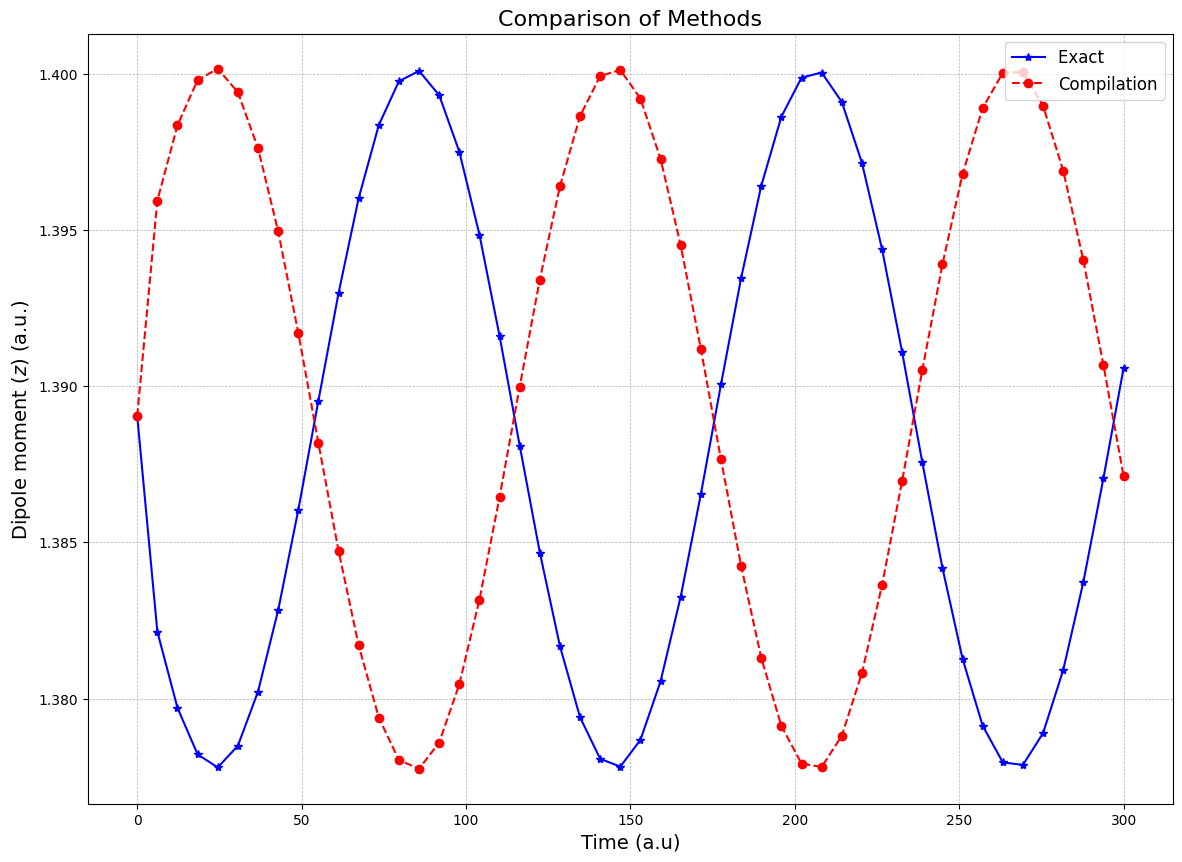

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# --- Bước 1: Tính toán giá trị kỳ vọng từ kết quả VQA mới ---

# Lấy các biến từ ô huấn luyện VQA mới (id: ee90b4ad)
# Đảm bảo ô đó đã được chạy
times_plot_pennylane_new = sorted(evolved_states.keys())
muz_plot_pennylane_new = []

for t in times_plot_pennylane_new:
    psi_t_current = evolved_states.get(t)
    if psi_t_current is not None:
        # Sử dụng lại ma trận Dz_matrix đã định nghĩa ở các ô trước
        exp_val = np.real(psi_t_current.conj().T @ dipole_matrix @ psi_t_current)
        muz_plot_pennylane_new.append(exp_val)

# --- Bước 2: Vẽ đồ thị so sánh TẤT CẢ các phương pháp ---
plt.figure(figsize=(14, 10))

# Dữ liệu "Ground Truth" mới tính từ ODE
if 'muz_plot_exact_ode' in locals() or 'muz_plot_exact_ode' in globals():
    plt.plot(times, muz_plot_exact_ode, label="Exact ", color='blue',marker='*', linestyle='-')

# Kết quả VQA mới (huấn luyện trên target chuẩn)
if muz_plot_pennylane_new:
    plt.plot(times_plot_pennylane_new, muz_plot_pennylane_new, label="Compilation", linestyle='--', marker='o', color='red', markersize=6)
    
# Kết quả VQA cũ (huấn luyện trên target xấp xỉ)
# if 'muz_plot_pennylane' in locals() or 'muz_plot_pennylane' in globals():
#     plt.plot(times_pennylane, muz_plot_pennylane, label="VQA (Trained on Integral Approx.)", marker='^', linestyle=':', color='orange', alpha=0.8)

# Các phương pháp xấp xỉ khác
# if 'muz_plot_trotter_t2' in locals() or 'muz_plot_trotter_t2' in globals():
#     plt.plot(times_for_trotter_plot, muz_plot_trotter_t2, label="Trotter 2nd", linestyle='-.',marker ='x', color='green', alpha=1)
# if 'muz_plot_magnus2' in locals() or 'muz_plot_magnus2' in globals():
#     plt.plot(times_plot_magnus2, muz_plot_np_magnus2, label="Magnus 2nd", linestyle='--',marker ='^', color='purple', alpha=1)
# if 'muz_plot_trotter_t1' in locals() or 'muz_plot_trotter_t1' in globals():
#     plt.plot(times_for_trotter_plot, muz_plot_trotter_t1, label="Trotter 1st", linestyle=':', marker='*', color='yellow', alpha=1)


# --- Định dạng đồ thị ---
plt.xlabel("Time (a.u)", fontsize=14)
plt.ylabel("Dipole moment ($z$) (a.u.)", fontsize=14)
plt.title("Comparison of Methods", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [ ]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from qiskit.quantum_info import Operator
import matplotlib.pyplot as plt

# Hàm tính trường điện từ E(t)
E0 = 0.01
Gamma = 0.25
def E_field(t):
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

def run_trotter_simulation(total_time, num_steps, H_static, H_dynamic_op, E_func, initial_state, order=1):
    """Chạy mô phỏng tiến hóa thời gian bằng phương pháp Trotter.
    
    Args:
        total_time (float): Tổng thời gian mô phỏng.
        num_steps (int): Số bước Trotter.
        H_static (SparsePauliOp): Toán tử Hamiltonian tĩnh (H_0).
        H_dynamic_op (SparsePauliOp): Toán tử của phần động (ví dụ: z_dipole).
        E_func (function): Hàm trả về E(t).
        initial_state (array): Vector trạng thái ban đầu.
        order (int): Bậc của phương pháp Trotter (1 hoặc 2).
        
    Returns:
        array: Vector trạng thái cuối cùng.
    """
    num_qubits = H_static.num_qubits
    dt = total_time / num_steps
    
    # Tạo mạch và khởi tạo trạng thái ban đầu
    circuit = QuantumCircuit(num_qubits)
    circuit.initialize(initial_state, range(num_qubits))
    
    # Áp dụng các bước Trotter
    for i in range(num_steps):
        t = (i + 0.5) * dt # Lấy giá trị E(t) ở giữa bước thời gian
        E_t = E_func(t)
        
        if order == 1:
            # Trotter bậc 1: U(dt) ≈ exp(-i*H0*dt) * exp(-i*V(t)*dt)
            circuit.append(PauliEvolutionGate(H_static, time=dt), range(num_qubits))
            circuit.append(PauliEvolutionGate(H_dynamic_op, time=E_t * dt), range(num_qubits))
        elif order == 2:
            # Trotter bậc 2: U(dt) ≈ exp(-i*H0*dt/2) * exp(-i*V(t)*dt) * exp(-i*H0*dt/2)
            circuit.append(PauliEvolutionGate(H_static, time=dt/2), range(num_qubits))
            circuit.append(PauliEvolutionGate(H_dynamic_op, time=E_t * dt), range(num_qubits))
            circuit.append(PauliEvolutionGate(H_static, time=dt/2), range(num_qubits))
        else:
            raise ValueError("Bậc Trotter phải là 1 hoặc 2.")
            
    # Tính toán trạng thái cuối cùng
    final_state = Statevector(circuit)
    return final_state.data, circuit

# --- Ví dụ sử dụng và so sánh ---
# T_final = 10.0      # Thời gian mô phỏng tổng cộng
#= num_trotter_steps = 100 # Số bước Trotter

# Lấy các toán tử và trạng thái ban đầu từ các ô trước
H0_op = H_0 # Chính là qubit_jw_op
z_dipole_op = dipole_qubit
psi0_vec = psi_0_vqe
num_qubits = H0_op.num_qubits



Bắt đầu mô phỏng Trotter để tính dipole moment...
Hoàn thành mô phỏng Trotter.


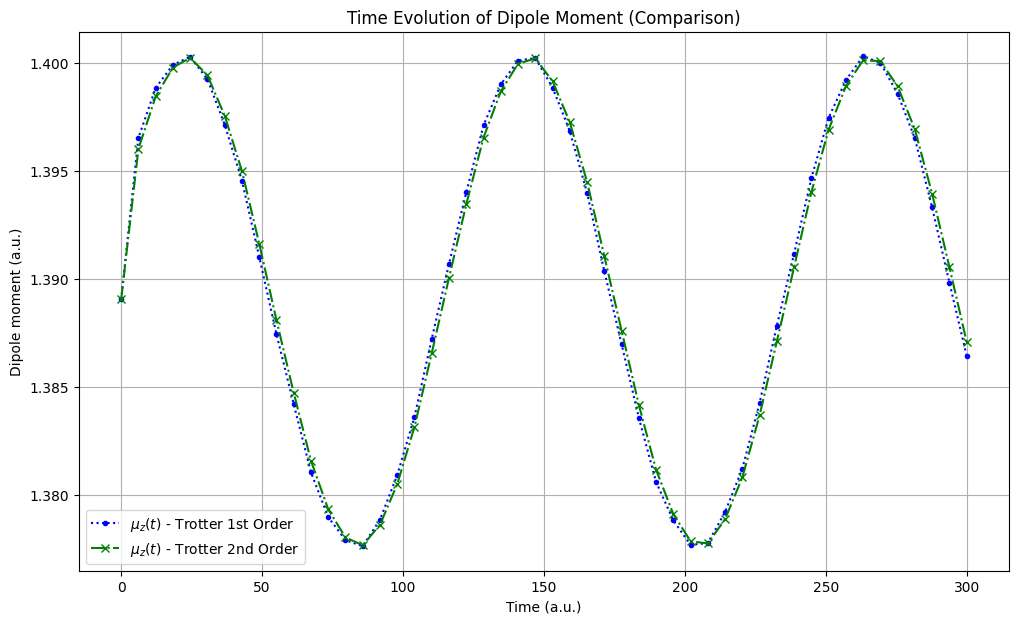

In [85]:
# --- Bước 1: Tính toán dipole moment theo thời gian bằng Trotter ---
# Sử dụng lại các biến đã định nghĩa từ các ô trước

times_for_trotter_plot = times
initial_state_vec = psi_0_vqe

muz_plot_trotter_t1 = []
muz_plot_trotter_t2 = []

# Cấu hình: số bước Trotter trên một đơn vị thời gian (a.u.)
# Tăng giá trị này để tăng độ chính xác (nhưng sẽ chạy chậm hơn)
steps_per_au = 10 

print("Bắt đầu mô phỏng Trotter để tính dipole moment...")

# Hàm tính giá trị kỳ vọng (đã có ở các ô trên)
def calculate_expectation_value(state_vector_flat, pauli_op_sparse):
    if pauli_op_sparse is None or state_vector_flat is None:
        return np.nan
    sv = Statevector(state_vector_flat)
    try:
        exp_val = sv.expectation_value(pauli_op_sparse)
        return exp_val.real 
    except Exception as e_exp:
        print(f"    Lỗi khi tính giá trị kỳ vọng: {e_exp}")
        return np.nan

for t in times_for_trotter_plot:
    # Với t=0, trạng thái chính là trạng thái ban đầu
    if t == 0:
        psi_t_t1 = initial_state_vec
        psi_t_t2 = initial_state_vec
    else:
        # Số bước trotter tỉ lệ với thời gian để đảm bảo độ chính xác
        num_steps = max(1, int(t * steps_per_au))
        psi_t_t1 = run_trotter_simulation(t, num_steps, H_0, dipole_qubit, E_field, initial_state_vec, order=1)
        psi_t_t2 = run_trotter_simulation(t, num_steps, H_0, dipole_qubit, E_field, initial_state_vec, order=2)

    # Tính giá trị kỳ vọng cho z-dipole
    muz_t1 = calculate_expectation_value(psi_t_t1, dipole_qubit)
    muz_t2 = calculate_expectation_value(psi_t_t2, dipole_qubit)
    
    muz_plot_trotter_t1.append(muz_t1)
    muz_plot_trotter_t2.append(muz_t2)

print("Hoàn thành mô phỏng Trotter.")

# --- Bước 2: Vẽ đồ thị so sánh tất cả các phương pháp ---

plt.figure(figsize=(12, 7))

# Dữ liệu từ các ô trước: Exact và VQA
#plt.plot(times_exact, muz_plot_exact, label="$\\mu_z(t)$ - Exact", marker='*', linestyle='--', color='black', zorder=5)
#plt.plot(times_pennylane, muz_plot_pennylane, label="$\\mu_z(t)$ - VQA", marker='^', linestyle='-', color='red')

# Dữ liệu Trotter vừa tính
plt.plot(times_for_trotter_plot, muz_plot_trotter_t1, label="$\\mu_z(t)$ - Trotter 1st Order", linestyle=':', marker='.', color='blue')
plt.plot(times_for_trotter_plot, muz_plot_trotter_t2, label="$\\mu_z(t)$ - Trotter 2nd Order", linestyle='-.', marker='x', color='green')

plt.xlabel("Time (a.u.)")
plt.ylabel("Dipole moment (a.u.)")
plt.title("Time Evolution of Dipole Moment (Comparison)")
plt.legend()
plt.grid(True)
plt.show()


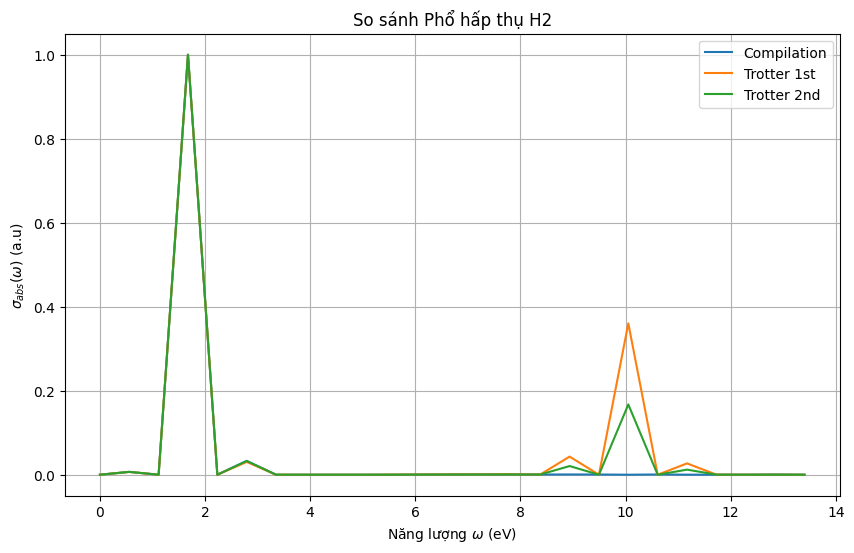

In [192]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftfreq, fftshift
from scipy import fftpack
from scipy.signal import windows
from scipy.constants import speed_of_light, physical_constants

# ================== KIỂM TRA INPUT ===================
if len(times_plot_np_magnus2) < 2:
    raise ValueError("Cần ít nhất 2 điểm thời gian để thực hiện FFT.")

# ================== THAM SỐ ===================
dt = times_plot_np_magnus2[1] - times_plot_np_magnus2[0]
N_points = len(times_plot_np_magnus2)
times = np.array(times_plot_np_magnus2)

gamma = 0.001
E0 = 0.01
Gamma = 0.25

Speed_of_light_au = speed_of_light / physical_constants["atomic unit of velocity"][0]
T = 300 
# damping = np.pi/T
# gamma = np.pi/T

# ================== HÀM HỖ TRỢ ===================

def damping(signal, dt, gamma):
    """Áp dụng hệ số tắt dần lên tín hiệu."""
    t = np.arange(len(signal)) * dt
    return signal * np.exp(-gamma * t)

# def windowed(signal):
#     """Áp dụng cửa sổ Blackman để giảm ringing."""
#     return signal * windows.blackman(len(signal))

def f_t_lorentz(t, E0, Gamma):
    """Trường điện từ Lorentz."""
    return (E0 / np.pi) * Gamma / (Gamma**2 + t**2)

def fourier_transform(signal, dt):
    """Fourier transform với chuẩn hóa chuẩn vật lý."""
    c = dt / (2 * np.pi)
    M = len(signal)//2
    N = 2*M  # ensure even number of points (faster)
    omega = fftpack.fftfreq(N, c)[:M]
    F = N * c * fftpack.ifft(signal[:N], overwrite_x=True)[:M]
    # N = len(signal) - (len(signal) % 2)  # làm chẵn nếu cần
    #omega = fftpack.fftfreq(N, c)[:N // 2]
    #F = N * c * fftpack.ifft(signal[:N], overwrite_x=True)[:N // 2]
    return omega, F

def absorption_spectrum(mu_omega, omega, E_omega, normalize=True):
    """Tính phổ hấp thụ từ mô men lưỡng cực và trường điện."""
    with np.errstate(divide='ignore', invalid='ignore'):
        alpha = np.zeros_like(mu_omega, dtype=complex)
        valid = np.abs(E_omega) > 1e-9
        alpha[valid] = mu_omega[valid] / E_omega[valid]
        sigma = (4 * np.pi * omega / Speed_of_light_au) * np.imag(alpha)
        sigma[sigma < 0] = 0
    return sigma / sigma.max() if normalize else sigma

def compute_discrete_spectrum(dipole_t, dt, E_t, gamma, normalize=True):
    """Tính phổ hấp thụ từ mô phỏng thời gian."""
    dipole_t = dipole_t - np.mean(dipole_t)
    dipole_damped = damping(dipole_t, dt, gamma)
    dipole_win = windowed(dipole_damped)
    E_win = windowed(E_t)

    omega, mu_omega = fourier_transform(dipole_win, dt)
    _, E_omega = fourier_transform(E_win, dt)

    sigma = absorption_spectrum(mu_omega, omega, E_omega, normalize)
    return omega, sigma

# ================== DỮ LIỆU TRƯỜNG VÀ DIPOLE ===================
E_t = f_t_lorentz(times, E0, Gamma)


# ================== TÍNH PHỔ ===================
omega1, sigma1 = compute_discrete_spectrum(muz_plot_pennylane_new, dt, E_t, gamma)
omega2, sigma2 = compute_discrete_spectrum(muz_plot_trotter_t1, dt, E_t, gamma)
omega3, sigma3 = compute_discrete_spectrum(muz_plot_exact_ode, dt, E_t, gamma)
omega4, sigma4 = compute_discrete_spectrum(muz_plot_trotter_t2, dt, E_t, gamma)
omega5, sigma5 = compute_discrete_spectrum(muz_plot_magnus2, dt, E_t, gamma)
hartree_to_ev = 27.211386245988
#omega_ev = omega_positive * hartree_to_ev

# ================== VẼ ĐỒ THỊ ===================
plt.figure(figsize=(10, 6))
plt.plot(omega1*hartree_to_ev, sigma1, label='Compilation')
plt.plot(omega2*hartree_to_ev, sigma2, label='Trotter 1st')
# plt.plot(omega3*hartree_to_ev, sigma3, label='Exact', linestyle='--')
plt.plot(omega4*hartree_to_ev, sigma4, label='Trotter 2nd')
# plt.plot(omega5*hartree_to_ev, sigma5, label='Magnus 2nd')
plt.xlabel("Năng lượng $\\omega$ (eV)")
plt.ylabel("$\\sigma_{abs}(\\omega)$ (a.u)")
plt.title("So sánh Phổ hấp thụ H2")
plt.grid(True)
plt.legend()
# plt.xlim(0, 1)  # Giới hạn để tập trung vào vùng quan tâm
# plt.ylim(bottom=0)
plt.show()

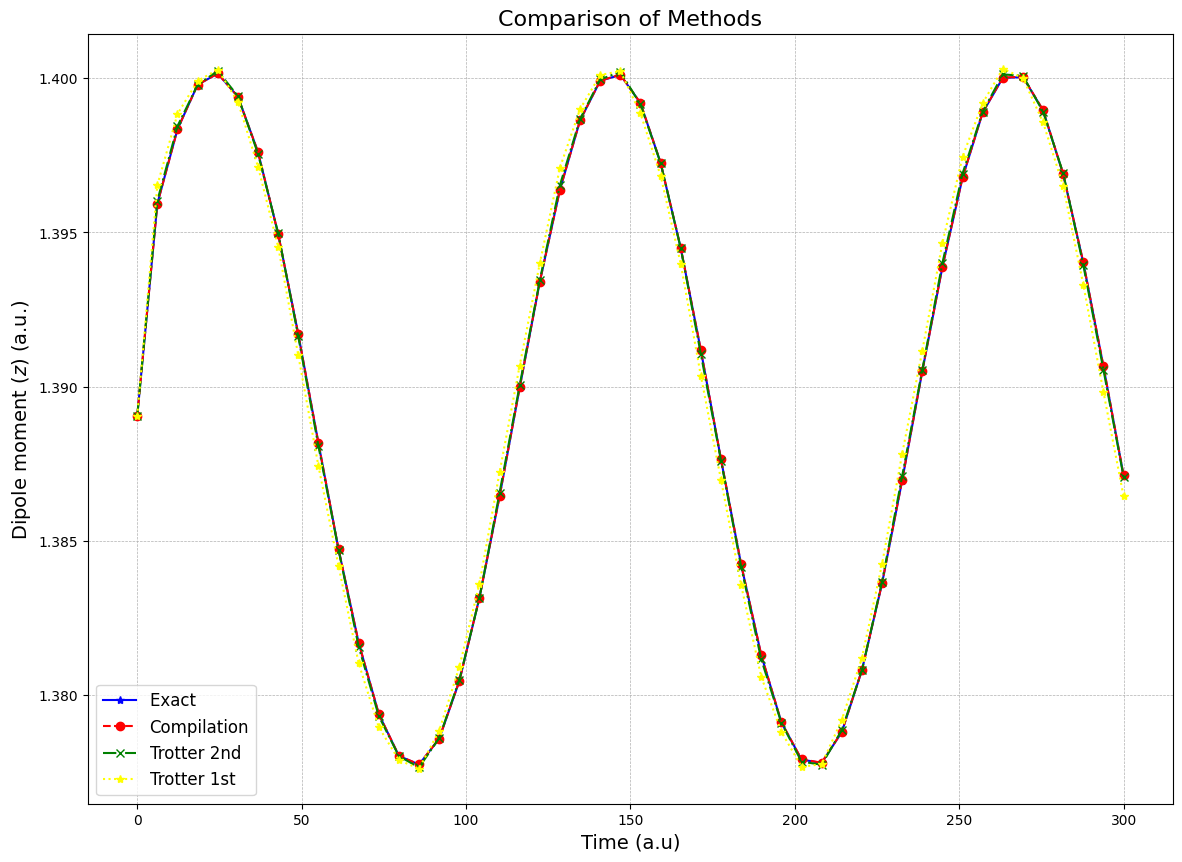

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# --- Bước 1: Tính toán giá trị kỳ vọng từ kết quả VQA mới ---

# Lấy các biến từ ô huấn luyện VQA mới (id: ee90b4ad)
# Đảm bảo ô đó đã được chạy
times_plot_pennylane_new = sorted(evolved_states.keys())
muz_plot_pennylane_new = []

for t in times_plot_pennylane_new:
    psi_t_current = evolved_states.get(t)
    if psi_t_current is not None:
        # Sử dụng lại ma trận Dz_matrix đã định nghĩa ở các ô trước
        exp_val = np.real(psi_t_current.conj().T @ dipole_matrix @ psi_t_current)
        muz_plot_pennylane_new.append(exp_val)

# --- Bước 2: Vẽ đồ thị so sánh TẤT CẢ các phương pháp ---
plt.figure(figsize=(14, 10))

# Dữ liệu "Ground Truth" mới tính từ ODE
if 'muz_plot_exact_ode' in locals() or 'muz_plot_exact_ode' in globals():
    plt.plot(times, muz_plot_exact_ode, label="Exact ", color='blue',marker='*', linestyle='-')

# Kết quả VQA mới (huấn luyện trên target chuẩn)
if muz_plot_pennylane_new:
    plt.plot(times_plot_pennylane_new, muz_plot_pennylane_new, label="Compilation", linestyle='--', marker='o', color='red', markersize=6)
    
# Kết quả VQA cũ (huấn luyện trên target xấp xỉ)
# if 'muz_plot_pennylane' in locals() or 'muz_plot_pennylane' in globals():
#     plt.plot(times_pennylane, muz_plot_pennylane, label="VQA (Trained on Integral Approx.)", marker='^', linestyle=':', color='orange', alpha=0.8)

# Các phương pháp xấp xỉ khác
if 'muz_plot_trotter_t2' in locals() or 'muz_plot_trotter_t2' in globals():
    plt.plot(times_for_trotter_plot, muz_plot_trotter_t2, label="Trotter 2nd", linestyle='-.',marker ='x', color='green', alpha=1)
# if 'muz_plot_magnus2' in locals() or 'muz_plot_magnus2' in globals():
#     plt.plot(times_plot_magnus2, muz_plot_np_magnus2, label="Magnus 2nd", linestyle='--',marker ='^', color='purple', alpha=1)
if 'muz_plot_trotter_t1' in locals() or 'muz_plot_trotter_t1' in globals():
    plt.plot(times_for_trotter_plot, muz_plot_trotter_t1, label="Trotter 1st", linestyle=':', marker='*', color='yellow', alpha=1)


# --- Định dạng đồ thị ---
plt.xlabel("Time (a.u)", fontsize=14)
plt.ylabel("Dipole moment ($z$) (a.u.)", fontsize=14)
plt.title("Comparison of Methods", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [104]:
# CELL MỚI: LƯU KẾT QUẢ DIPOLE RA FILE TXT

import numpy as np

# Giả định rằng các biến này đã được tính toán ở các ô trước:
# - times_for_training: Mảng thời gian
# - muz_plot_exact_ode: Dữ liệu dipole từ ODE Solver (Exact)
# - muz_plot_pennylane_new: Dữ liệu dipole từ VQA đã được huấn luyện (Train)

output_filename = "dipole_thesis_perfect.txt"

try:
    with open(output_filename, "w") as f:
        # Ghi dòng tiêu đề cho các cột
        f.write("# Time (fs)   Dipole_Exact (a.u.)   Dipole_Train (a.u.)  Dipole_Trotter1 (a.u.)   Dipole_Trotter2 (a.u.)   Dipole_Magnus2 (a.u.)   \n")
        
        # Lặp qua từng điểm thời gian và ghi dữ liệu
        for i in range(len(times_for_training)):
            time_val = times_for_training[i]
            dipole_exact = muz_plot_exact_ode[i]
            dipole_magnus2 = muz_plot_magnus2[i]
            dipole_trotter1 = muz_plot_trotter_t1[i]
            dipole_trotter2 = muz_plot_trotter_t2[i]
            dipole_train = muz_plot_pennylane_new[i]
            
            # Định dạng và ghi một dòng dữ liệu
            f.write(f"{time_val:<15.6f} {dipole_exact:<21.12f} {dipole_train:<21.12f} {dipole_trotter1:<21.12f} {dipole_trotter2:<21.12f} {dipole_magnus2:<21.12f}\n")
            
    print(f"Đã lưu kết quả thành công vào file: {output_filename}")

except NameError:
    print("Lỗi: Không tìm thấy các biến cần thiết (times_for_training, muz_plot_exact_ode, muz_plot_pennylane_new).")
    print("Vui lòng đảm bảo bạn đã chạy các ô code tính toán và vẽ đồ thị trước khi chạy ô này.")


Đã lưu kết quả thành công vào file: dipole_thesis_perfect.txt


In [107]:
# CELL MỚI: GHI DỮ LIỆU PHỔ HẤP THỤ (ĐÃ VẼ) RA FILE

try:
    # Tên file để lưu kết quả
    output_filename = "absorption_spectra_thesis_perfect.txt"

    with open(output_filename, "w") as f:
        # Ghi dòng tiêu đề cho các cột, đơn vị là eV giống như trên đồ thị
        f.write("# Energy (eV)   Sigma_Exact (a.u.) Sigma_Compilation (a.u.)     Sigma_Trotter1 (a.u.)   Sigma_Trotter2 (a.u.)   Sigma_Magnus2 (a.u.)\n")
        omega_ev = omega1*hartree_to_ev
        # Lặp qua dữ liệu đã tính toán và ghi ra file
        # omega_ev, sigma_abs_pennylane, sigma_abs_exact là các biến từ ô code vẽ đồ thị
        for i in range(len(omega_ev)):
            energy_val = omega_ev[i]
            sigma_pennylane = sigma1[i]
            sigma_trotter1 = sigma2[i]
            sigma_exact = sigma3[i]
            sigma_trotter2 = sigma4[i]
            sigma_magnus2 = sigma5[i]
            
            # Định dạng và ghi một dòng dữ liệu
            f.write(f"{energy_val:<15.6f}{sigma_exact:<21.12f} {sigma_pennylane:<26.12f}  {sigma_trotter1:<21.12f} {sigma_trotter2:<21.12f} {sigma_magnus2:<21.12f}\n")
            
    print(f"Đã lưu dữ liệu phổ hấp thụ thành công vào file: {output_filename}")

except NameError:
    print("Lỗi: Không tìm thấy các biến cần thiết (omega_ev, sigma_abs_pennylane, sigma_abs_exact).")
    print("Vui lòng đảm bảo bạn đã chạy ô code tính toán và vẽ đồ thị phổ hấp thụ ngay trước khi chạy ô này.")
except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")

Đã lưu dữ liệu phổ hấp thụ thành công vào file: absorption_spectra_thesis_perfect.txt


In [108]:
# CELL MỚI: TÍNH VÀ LƯU FIDELITY (TRAIN vs EXACT) RA FILE TXT

import numpy as np

output_filename = "fidelity_train_vs_exact_thesis_perfect.txt"

try:
    # --- Bước 1: Chuẩn hóa dữ liệu đầu vào ---
    # Đảm bảo `all_psi_t_pennylane_new` được chuyển sang dạng list
    # để tương thích với `all_psi_t_exact_ode`
    if isinstance(evolved_states, dict):
        print("Phát hiện `all_psi_t_pennylane_new` là dictionary. Đang chuyển đổi sang list...")
        sorted_times = sorted(evolved_states.keys())
        psi_train_list = [evolved_states[t] for t in sorted_times]
    else:
        print("`all_psi_t_pennylane_new` đã là list.")
        # Giả định biến times_for_training tồn tại nếu `all_psi_t_pennylane_new` là list
        sorted_times = times_for_training 
        psi_train_list = evolved_states
        
    # Giả định `all_psi_t_exact_ode` đã là một list/array có thể truy cập bằng chỉ số nguyên
    psi_exact_list = all_psi_t_exact_ode

    # Kiểm tra độ dài để đảm bảo tính toán chính xác
    if len(psi_train_list) != len(psi_exact_list):
        raise ValueError(f"Lỗi: Số lượng trạng thái 'train' ({len(psi_train_list)}) và 'exact' ({len(psi_exact_list)}) không khớp nhau.")

    # --- Bước 2: Tính toán Fidelity ---
    print("Đang tính toán Fidelity...")
    fidelities = []
    for i in range(len(psi_train_list)):
        psi_exact = psi_exact_list[i]
        psi_train = psi_train_list[i]
        
        # Công thức: F = |<psi_exact|psi_train>|^2
        inner_product = np.dot(np.conj(psi_exact), psi_train)
        fidelity = np.abs(inner_product)**2
        fidelities.append(fidelity)
    
    # --- Bước 3: Ghi kết quả ra file ---
    print(f"Đang ghi kết quả ra file '{output_filename}'...")
    with open(output_filename, "w") as f:
        # Ghi dòng tiêu đề cho các cột
        f.write("# Time (fs)   Fidelity\n")
        
        # Ghi dữ liệu từng dòng, căn chỉnh cho đẹp
        for i in range(len(sorted_times)):
            f.write(f"{sorted_times[i]:<15.8f} {fidelities[i]:<15.8f}\n")
            
    print(f"\nHoàn tất! Đã lưu thành công dữ liệu Fidelity vào file '{output_filename}'.")
    print("File chứa 2 cột: Thời gian và Fidelity.")

except Exception as e:
    print(f"Đã xảy ra lỗi không mong muốn: {e}")
    print("Vui lòng đảm bảo các biến `all_psi_t_pennylane_new` và `all_psi_t_exact_ode` đã được tính toán ở các ô trước.")


Phát hiện `all_psi_t_pennylane_new` là dictionary. Đang chuyển đổi sang list...
Đang tính toán Fidelity...
Đang ghi kết quả ra file 'fidelity_train_vs_exact_thesis_perfect.txt'...

Hoàn tất! Đã lưu thành công dữ liệu Fidelity vào file 'fidelity_train_vs_exact_thesis_perfect.txt'.
File chứa 2 cột: Thời gian và Fidelity.


In [109]:
import numpy as np

# Đọc file, bỏ qua dòng đầu (header)
data = np.loadtxt('absorption_spectra_thesis_perfect.txt', skiprows=1)

# Cột 0: Energy (eV)
energy = data[:, 0]
sigma_exact = data[:, 1]
sigma_compilation = data[:, 2]
sigma_trotter1 = data[:, 3]
sigma_trotter2 = data[:, 4]
sigma_magnus2 = data[:, 5]

In [110]:
import pandas as pd

df = pd.read_csv('absorption_spectra_thesis_perfect.txt', 
                 delim_whitespace=True, 
                 comment='#', 
                 header=None,
                 skiprows=1)

df.columns = [
    'Energy_eV', 'Sigma_Exact', 'Sigma_Compilation', 
    'Sigma_Trotter1', 'Sigma_Trotter2', 'Sigma_Magnus2'
]

/tmp/ipykernel_671844/2989444436.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('absorption_spectra_thesis_perfect.txt',


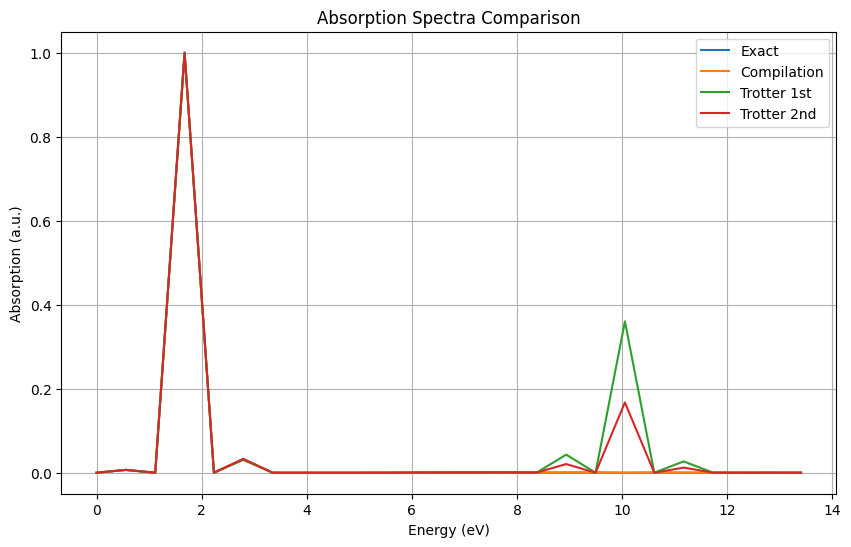

In [114]:
plt.figure(figsize=(10,6))
plt.plot(df['Energy_eV'], df['Sigma_Exact'], label='Exact')
plt.plot(df['Energy_eV'], df['Sigma_Compilation'], label='Compilation')
plt.plot(df['Energy_eV'], df['Sigma_Trotter1'], label='Trotter 1st')
plt.plot(df['Energy_eV'], df['Sigma_Trotter2'], label='Trotter 2nd')
# plt.plot(df['Energy_eV'], df['Sigma_Magnus2'], label='Magnus 2nd')
plt.xlabel('Energy (eV)')
plt.ylabel('Absorption (a.u.)')
plt.title('Absorption Spectra Comparison')
plt.legend()
plt.grid(True)
plt.show()

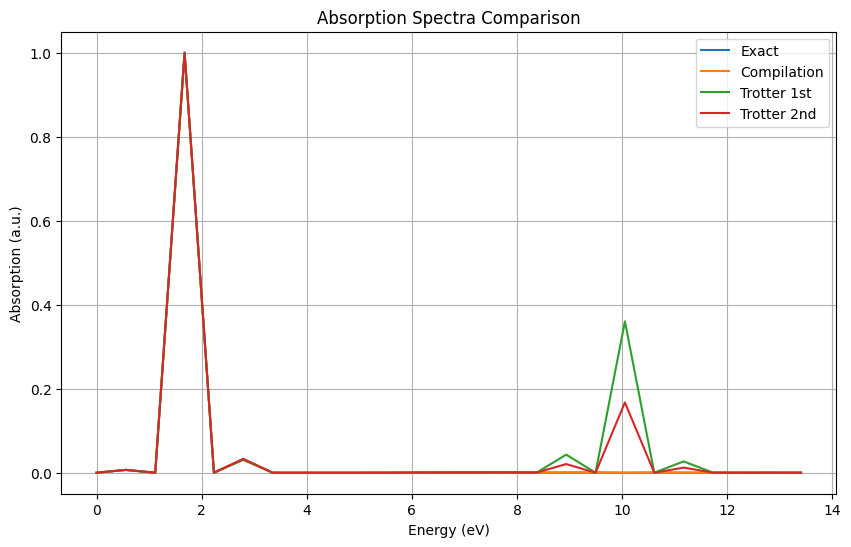

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(energy, sigma_exact, label='Exact')
plt.plot(energy, sigma_compilation, label='Compilation')
plt.plot(energy, sigma_trotter1, label='Trotter 1st')
plt.plot(energy, sigma_trotter2, label='Trotter 2nd')
# plt.plot(energy, sigma_magnus2, label='Magnus 2nd')
plt.xlabel('Energy (eV)')
plt.ylabel('Absorption (a.u.)')
plt.title('Absorption Spectra Comparison')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_671844/3083432191.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('dipole_thesis_perfect.txt',


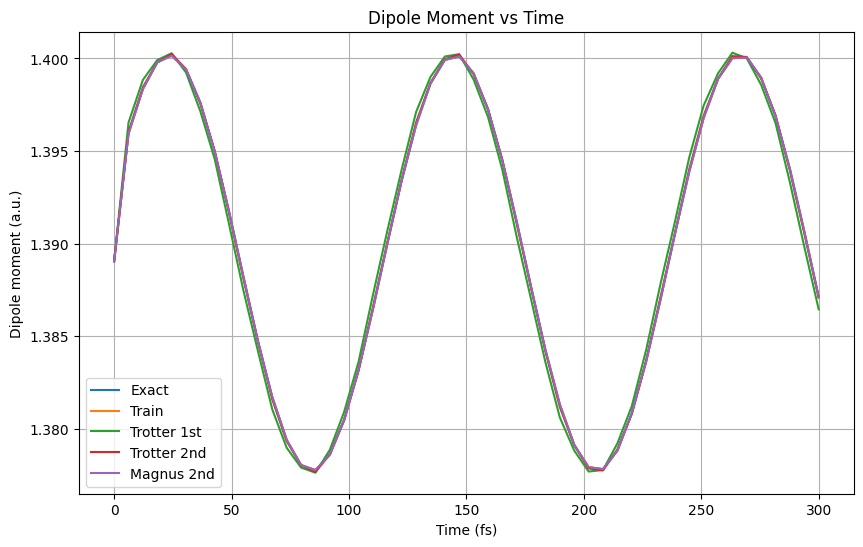

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc file, bỏ qua dòng đầu (header)
df = pd.read_csv('dipole_thesis_perfect.txt', 
                 delim_whitespace=True, 
                 comment='#', 
                 header=None, 
                 skiprows=1)

# Đặt tên cột cho dễ dùng
df.columns = [
    'Time_fs', 'Dipole_Exact', 'Dipole_Train', 
    'Dipole_Trotter1', 'Dipole_Trotter2', 'Dipole_Magnus2'
]

# Vẽ đồ thị
plt.figure(figsize=(10,6))
plt.plot(df['Time_fs'], df['Dipole_Exact'], label='Exact')
plt.plot(df['Time_fs'], df['Dipole_Train'], label='Train')
plt.plot(df['Time_fs'], df['Dipole_Trotter1'], label='Trotter 1st')
plt.plot(df['Time_fs'], df['Dipole_Trotter2'], label='Trotter 2nd')
plt.plot(df['Time_fs'], df['Dipole_Magnus2'], label='Magnus 2nd')
plt.xlabel('Time (fs)')
plt.ylabel('Dipole moment (a.u.)')
plt.title('Dipole Moment vs Time')
plt.legend()
plt.grid(True)
plt.show()

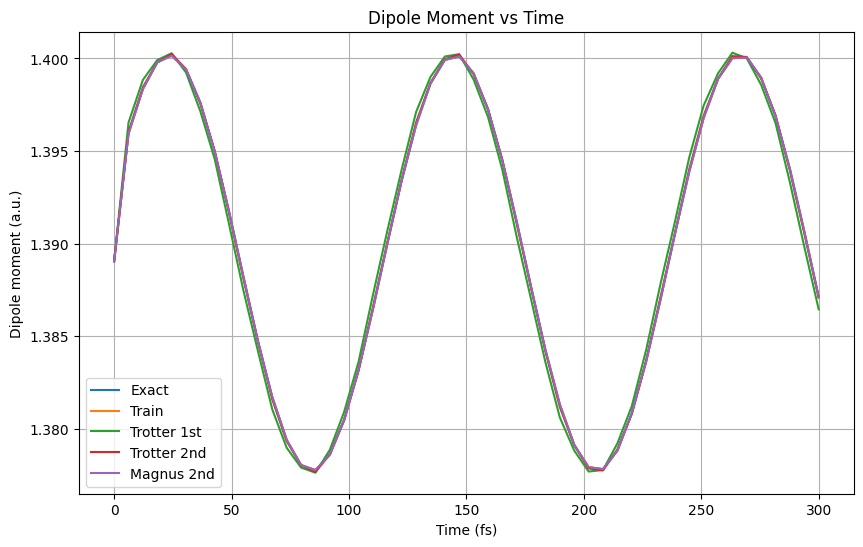

In [116]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('dipole_thesis_perfect.txt', skiprows=1)
time = data[:, 0]
dipole_exact = data[:, 1]
dipole_train = data[:, 2]
dipole_trotter1 = data[:, 3]
dipole_trotter2 = data[:, 4]
dipole_magnus2 = data[:, 5]

plt.figure(figsize=(10,6))
plt.plot(time, dipole_exact, label='Exact')
plt.plot(time, dipole_train, label='Train')
plt.plot(time, dipole_trotter1, label='Trotter 1st')
plt.plot(time, dipole_trotter2, label='Trotter 2nd')
plt.plot(time, dipole_magnus2, label='Magnus 2nd')
plt.xlabel('Time (fs)')
plt.ylabel('Dipole moment (a.u.)')
plt.title('Dipole Moment vs Time')
plt.legend()
plt.grid(True)
plt.show()

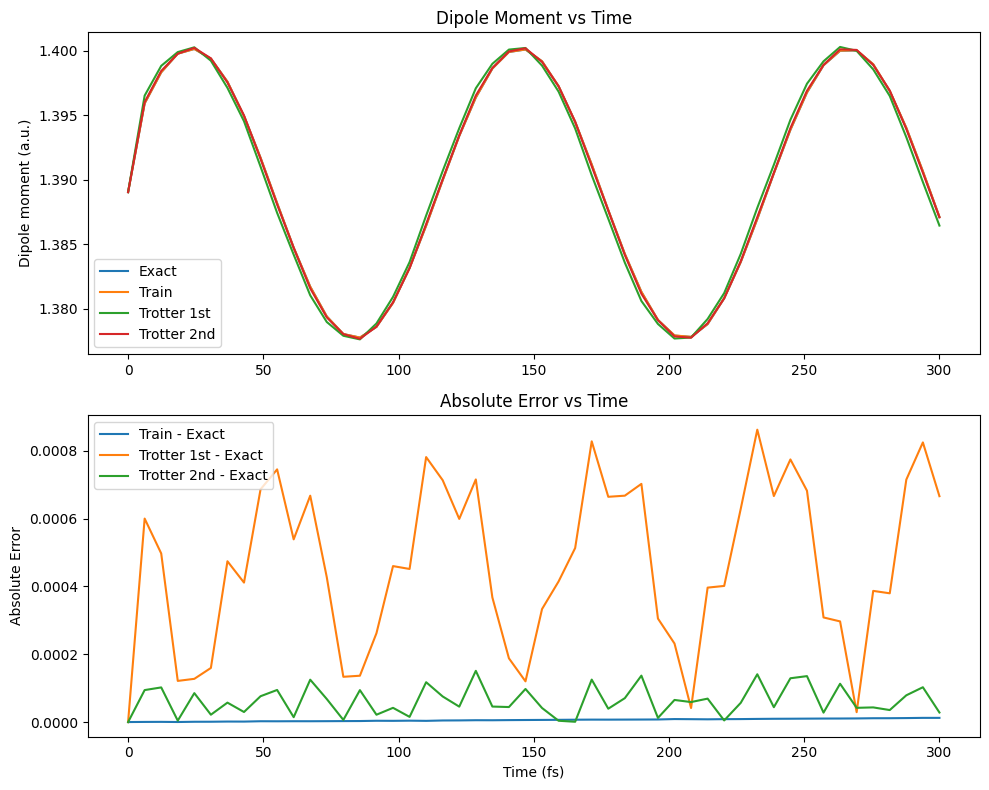

In [151]:
plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.plot(time, dipole_exact, label='Exact')
plt.plot(time, dipole_train, label='Train')
plt.plot(time, dipole_trotter1, label='Trotter 1st')
plt.plot(time, dipole_trotter2, label='Trotter 2nd')
# plt.plot(time, dipole_magnus2, label='Magnus 2nd')
plt.ylabel('Dipole moment (a.u.)')
plt.legend()
plt.title('Dipole Moment vs Time')

plt.subplot(2,1,2)
plt.plot(time, np.abs(dipole_train - dipole_exact), label='Train - Exact')
plt.plot(time, np.abs(dipole_trotter1 - dipole_exact), label='Trotter 1st - Exact')
plt.plot(time, np.abs(dipole_trotter2 - dipole_exact), label='Trotter 2nd - Exact')
# plt.plot(time, np.abs(dipole_magnus2 - dipole_exact), label='Magnus 2nd - Exact')
plt.xlabel('Time (fs)')
plt.ylabel('Absolute Error')
plt.legend()
plt.title('Absolute Error vs Time')
plt.tight_layout()
plt.show()

In [118]:
def print_error_stats(label, y_pred, y_true):
    mae = np.mean(np.abs(y_pred - y_true))
    max_err = np.max(np.abs(y_pred - y_true))
    print(f"{label}: MAE = {mae:.3e}, Max Error = {max_err:.3e}")

print_error_stats('Train', dipole_train, dipole_exact)
print_error_stats('Trotter 1st', dipole_trotter1, dipole_exact)
print_error_stats('Trotter 2nd', dipole_trotter2, dipole_exact)
print_error_stats('Magnus 2nd', dipole_magnus2, dipole_exact)

Train: MAE = 6.118e-06, Max Error = 1.248e-05
Trotter 1st: MAE = 4.623e-04, Max Error = 8.626e-04
Trotter 2nd: MAE = 6.283e-05, Max Error = 1.512e-04
Magnus 2nd: MAE = 1.577e-05, Max Error = 3.450e-05


In [120]:
import pandas as pd

df = pd.read_csv('absorption_spectra_thesis_perfect.txt',
                 delim_whitespace=True,
                 comment='#',
                 header=None,
                 skiprows=1)

df.columns = [
    'Energy_eV', 'Sigma_Exact', 'Sigma_Compilation',
    'Sigma_Trotter1', 'Sigma_Trotter2', 'Sigma_Magnus2'
]

/tmp/ipykernel_671844/1868914730.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('absorption_spectra_thesis_perfect.txt',


In [121]:
err_compilation = abs(df['Sigma_Compilation'] - df['Sigma_Exact'])
err_trotter1 = abs(df['Sigma_Trotter1'] - df['Sigma_Exact'])
err_trotter2 = abs(df['Sigma_Trotter2'] - df['Sigma_Exact'])
err_magnus2 = abs(df['Sigma_Magnus2'] - df['Sigma_Exact'])

In [122]:
def print_error_stats(label, y_pred, y_true):
    mae = np.mean(np.abs(y_pred - y_true))
    max_err = np.max(np.abs(y_pred - y_true))
    print(f"{label}: MAE = {mae:.3e}, Max Error = {max_err:.3e}")

print_error_stats('Train', dipole_train, dipole_exact)
print_error_stats('Trotter 1st', dipole_trotter1, dipole_exact)
print_error_stats('Trotter 2nd', dipole_trotter2, dipole_exact)
print_error_stats('Magnus 2nd', dipole_magnus2, dipole_exact)

Train: MAE = 6.118e-06, Max Error = 1.248e-05
Trotter 1st: MAE = 4.623e-04, Max Error = 8.626e-04
Trotter 2nd: MAE = 6.283e-05, Max Error = 1.512e-04
Magnus 2nd: MAE = 1.577e-05, Max Error = 3.450e-05


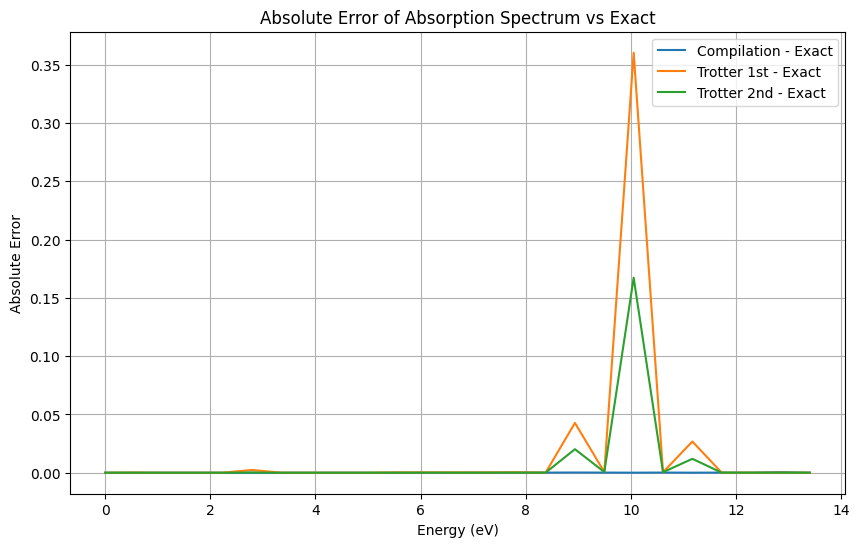

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df['Energy_eV'], err_compilation, label='Compilation - Exact')
plt.plot(df['Energy_eV'], err_trotter1, label='Trotter 1st - Exact')
plt.plot(df['Energy_eV'], err_trotter2, label='Trotter 2nd - Exact')
# plt.plot(df['Energy_eV'], err_magnus2, label='Magnus 2nd - Exact')
plt.xlabel('Energy (eV)')
plt.ylabel('Absolute Error')
plt.title('Absolute Error of Absorption Spectrum vs Exact')
plt.legend()
plt.grid(True)
plt.show()

In [127]:
import pandas as pd

df_dipole = pd.read_csv('dipole_thesis_perfect.txt',
                        delim_whitespace=True,
                        comment='#',
                        header=None,
                        skiprows=1)
df_dipole.columns = [
    'Time_fs', 'Dipole_Exact', 'Dipole_Train',
    'Dipole_Trotter1', 'Dipole_Trotter2', 'Dipole_Magnus2'
]

df_dipole['Error_Train'] = abs(df_dipole['Dipole_Train'] - df_dipole['Dipole_Exact'])
df_dipole['Error_Trotter1'] = abs(df_dipole['Dipole_Trotter1'] - df_dipole['Dipole_Exact'])
df_dipole['Error_Trotter2'] = abs(df_dipole['Dipole_Trotter2'] - df_dipole['Dipole_Exact'])
df_dipole['Error_Magnus2'] = abs(df_dipole['Dipole_Magnus2'] - df_dipole['Dipole_Exact'])

df_dipole[['Time_fs', 'Error_Train', 'Error_Trotter1', 'Error_Trotter2', 'Error_Magnus2']].to_csv(
    'dipole_errors.txt', sep='\t', index=False, float_format='%.10e'
)

/tmp/ipykernel_671844/580138185.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_dipole = pd.read_csv('dipole_thesis_perfect.txt',


In [128]:
df_abs = pd.read_csv('absorption_spectra_thesis_perfect.txt',
                     delim_whitespace=True,
                     comment='#',
                     header=None,
                     skiprows=1)
df_abs.columns = [
    'Energy_eV', 'Sigma_Exact', 'Sigma_Compilation',
    'Sigma_Trotter1', 'Sigma_Trotter2', 'Sigma_Magnus2'
]

df_abs['Error_Compilation'] = abs(df_abs['Sigma_Compilation'] - df_abs['Sigma_Exact'])
df_abs['Error_Trotter1'] = abs(df_abs['Sigma_Trotter1'] - df_abs['Sigma_Exact'])
df_abs['Error_Trotter2'] = abs(df_abs['Sigma_Trotter2'] - df_abs['Sigma_Exact'])
df_abs['Error_Magnus2'] = abs(df_abs['Sigma_Magnus2'] - df_abs['Sigma_Exact'])

df_abs[['Energy_eV', 'Error_Compilation', 'Error_Trotter1', 'Error_Trotter2', 'Error_Magnus2']].to_csv(
    'absorption_errors.txt', sep='\t', index=False, float_format='%.10e'
)

/tmp/ipykernel_671844/2122924515.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_abs = pd.read_csv('absorption_spectra_thesis_perfect.txt',


/tmp/ipykernel_671844/1283842636.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_cost = pd.read_csv('cost_thesis_perfect.txt',


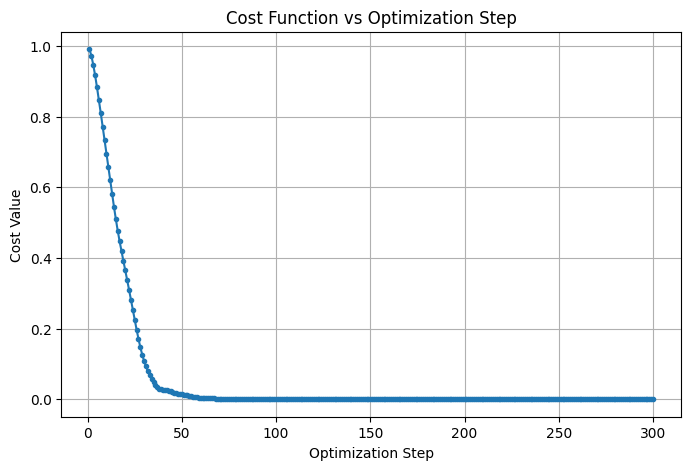

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc file, bỏ qua dòng đầu (header)
df_cost = pd.read_csv('cost_thesis_perfect.txt',
                      delim_whitespace=True,
                      comment='#',
                      header=None,
                      skiprows=1)

df_cost.columns = ['Step', 'Cost']

plt.figure(figsize=(8,5))
plt.plot(df_cost['Step'], df_cost['Cost'], marker='.')
plt.xlabel('Optimization Step')
plt.ylabel('Cost Value')
plt.title('Cost Function vs Optimization Step')
#plt.yscale('log')  # Nếu muốn nhìn rõ quá trình hội tụ
plt.grid(True)
plt.show()

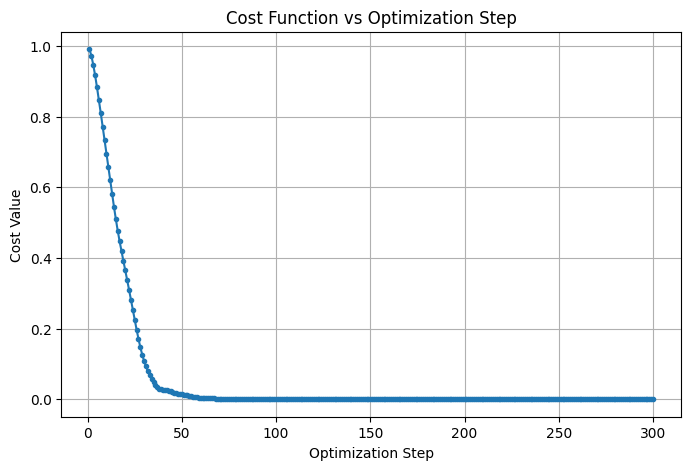

In [132]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('cost_thesis_perfect.txt', skiprows=1)
steps = data[:, 0]
costs = data[:, 1]

plt.figure(figsize=(8,5))
plt.plot(steps, costs, marker='.')
plt.xlabel('Optimization Step')
plt.ylabel('Cost Value')
plt.title('Cost Function vs Optimization Step')
#plt.yscale('log')  # Nếu muốn nhìn rõ quá trình hội tụ
plt.grid(True)
plt.show()

/tmp/ipykernel_671844/3811178252.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_err = pd.read_csv('absorption_errors.txt',


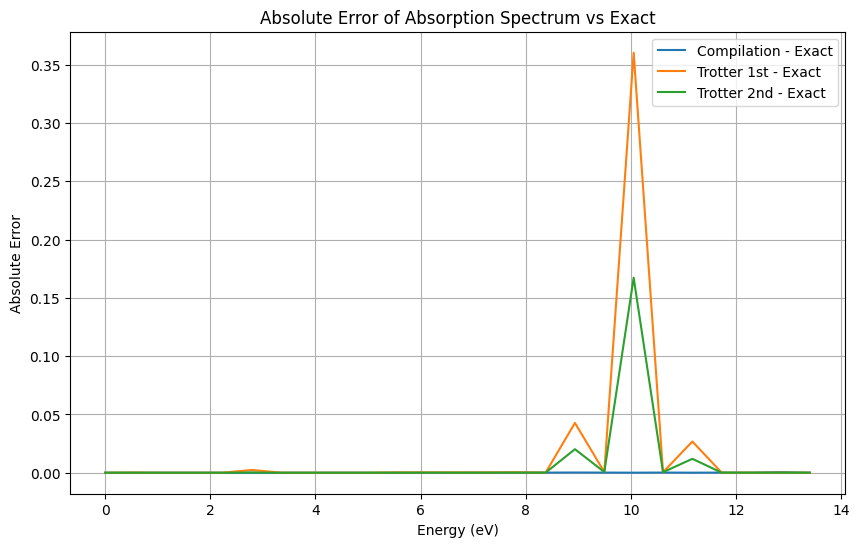

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc file sai số
df_err = pd.read_csv('absorption_errors.txt', 
                     delim_whitespace=True, 
                     comment='#')

# Vẽ các đường sai số
plt.figure(figsize=(10,6))
plt.plot(df_err['Energy_eV'], df_err['Error_Compilation'], label='Compilation - Exact')
plt.plot(df_err['Energy_eV'], df_err['Error_Trotter1'], label='Trotter 1st - Exact')
plt.plot(df_err['Energy_eV'], df_err['Error_Trotter2'], label='Trotter 2nd - Exact')
# plt.plot(df_err['Energy_eV'], df_err['Error_Magnus2'], label='Magnus 2nd - Exact')
plt.xlabel('Energy (eV)')
plt.ylabel('Absolute Error')
plt.title('Absolute Error of Absorption Spectrum vs Exact')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_671844/76790780.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_fid = pd.read_csv('fidelity_train_vs_exact_thesis_perfect.txt',


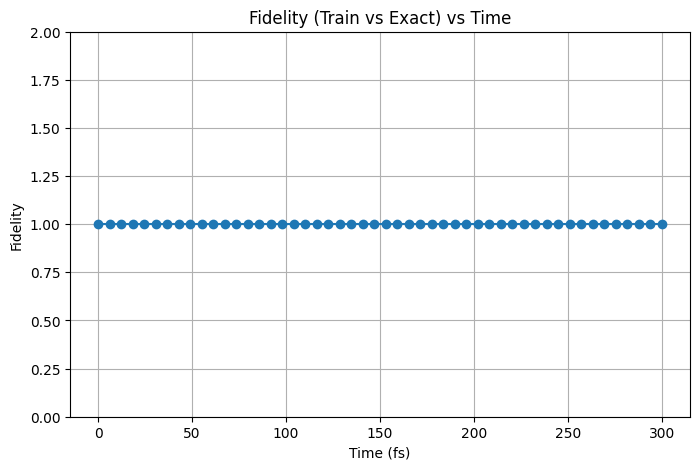

In [141]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc file, bỏ qua dòng đầu (header)
df_fid = pd.read_csv('fidelity_train_vs_exact_thesis_perfect.txt',
                     delim_whitespace=True,
                     comment='#',
                     header=None,
                     skiprows=1)

df_fid.columns = ['Time_fs', 'Fidelity']

plt.figure(figsize=(8,5))
plt.plot(df_fid['Time_fs'], df_fid['Fidelity'], marker='o')
plt.xlabel('Time (fs)')
plt.ylabel('Fidelity')
plt.title('Fidelity (Train vs Exact) vs Time')
plt.ylim(0, 2)  # Zoom vào vùng giá trị cao nếu muốn
plt.grid(True)
plt.show()

In [147]:
frobenius_norms = []
for i, t in enumerate(times):
    U_train = optimized_unitaries[t]
    U_exact = target_unitaries_list[i]
    fro_norm = np.linalg.norm(U_train - U_exact, ord='fro')
    frobenius_norms.append(fro_norm)

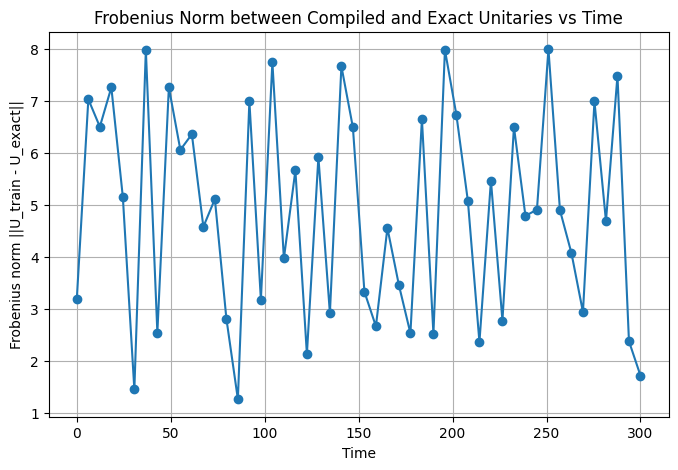

In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(times, frobenius_norms, marker='o')
plt.xlabel('Time')
plt.ylabel('Frobenius norm ||U_train - U_exact||')
plt.title('Frobenius Norm between Compiled and Exact Unitaries vs Time')
plt.grid(True)
plt.show()

In [156]:
diff_norms = []
for i, t in enumerate(times):
    U_train = optimized_unitaries[t]
    U_exact = target_unitaries_list[i]
    psi_0 = psi_0_vqe.flatten()
    psi_train = U_train @ psi_0
    psi_exact = U_exact @ psi_0
    norm = np.linalg.norm(psi_train - psi_exact)
    diff_norms.append(norm)
    # print(f"t={t:.2f} | State difference norm: {norm:.3e}")

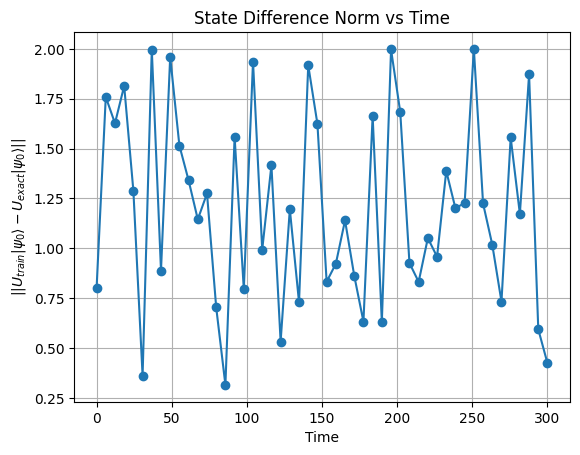

In [157]:
import matplotlib.pyplot as plt
plt.plot(times, diff_norms, marker='o')
plt.xlabel('Time')
plt.ylabel(r'$|| U_{train}|\psi_0\rangle - U_{exact}|\psi_0\rangle ||$')
plt.title('State Difference Norm vs Time')
plt.grid(True)
plt.show()